# Deteksi Penyakit Jantung

In [1]:
# Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

🔢 Shape: (1025, 14)

📋 Kolom: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

🧠 Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB

❌ Missing values per kolom:
age         0
sex

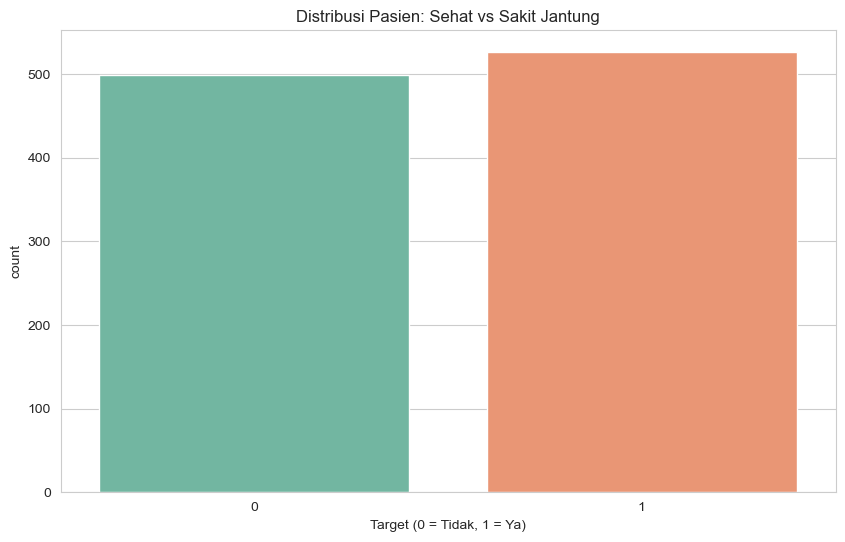

In [2]:
# Muat dataset dari file heart.csv
df = pd.read_csv("heart.csv")

# Informasi dasar
print("🔢 Shape:", df.shape)
print("\n📋 Kolom:", list(df.columns))
print("\n🧠 Info dataset:")
df.info()

# Cek missing values
print("\n❌ Missing values per kolom:")
print(df.isnull().sum())

# Distribusi target
print("\n🎯 Distribusi target:")
print(df["target"].value_counts())
sns.countplot(x='target', data=df, palette='Set2')
plt.title("Distribusi Pasien: Sehat vs Sakit Jantung")
plt.xlabel("Target (0 = Tidak, 1 = Ya)")
plt.show()

In [3]:
# Feature Engineering
df['age_group'] = pd.cut(df['age'], bins=[0, 40, 55, 65, 100], labels=['Muda', 'Dewasa Muda', 'Dewasa Tua', 'Lansia'])
df['chol_level'] = pd.cut(df['chol'], bins=[0, 200, 240, 400, 600], labels=['Normal', 'Batas', 'Tinggi', 'Sangat Tinggi'])
df['thalach_level'] = pd.cut(df['thalach'], bins=[0, 120, 150, 200], labels=['Rendah', 'Sedang', 'Tinggi'])
df['trestbps_level'] = pd.cut(df['trestbps'], bins=[0, 120, 140, 200], labels=['Normal', 'Prehipertensi', 'Hipertensi'])
df['oldpeak_level'] = pd.cut(df['oldpeak'], bins=[-1, 0, 1, 3, 10], labels=['Tidak', 'Ringan', 'Sedang', 'Berat'])

le = LabelEncoder()
for col in ['age_group', 'chol_level', 'thalach_level', 'trestbps_level', 'oldpeak_level']:
    df[col] = le.fit_transform(df[col])

X = df.drop("target", axis=1)
y = df["target"]

# memisahkan data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [4]:
# Pipeline untuk masing-masing model
models = {}

# 1. Logistic Regression
models['Logistic Regression'] = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

#2. Random FOrest
models['Random Forest'] = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(
        n_estimators=50,          # Kurangi jumlah pohon
        max_depth=5,              # Batasi kedalaman pohon
        min_samples_split=10,     # Minimum 10 data untuk split
        min_samples_leaf=5,       # Minimum 5 data di leaf
        random_state=42
    ))
])



In [5]:
# Dictionary untuk menyimpan hasil evaluasi
results = {}

for name, model in models.items():
    print(f"\n🔍 Evaluasi {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metrik
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')

    results[name] = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'AUC-ROC': auc,
        'CV F1-mean': cv_scores.mean(),
        'CV F1-std': cv_scores.std(),
        'Predictions': y_pred,
        'Probabilities': y_proba
    }

    print(f"  Accuracy  : {acc:.4f}")
    print(f"  Precision : {prec:.4f}")
    print(f"  Recall    : {rec:.4f}")
    print(f"  F1-score  : {f1:.4f}")
    print(f"  AUC-ROC   : {auc:.4f}")
    print(f"  CV F1     : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


🔍 Evaluasi Logistic Regression...
  Accuracy  : 0.8049
  Precision : 0.7731
  Recall    : 0.8762
  F1-score  : 0.8214
  AUC-ROC   : 0.9253
  CV F1     : 0.8487 ± 0.0280

🔍 Evaluasi Random Forest...
  Accuracy  : 0.9073
  Precision : 0.8707
  Recall    : 0.9619
  F1-score  : 0.9140
  AUC-ROC   : 0.9730
  CV F1     : 0.8956 ± 0.0159


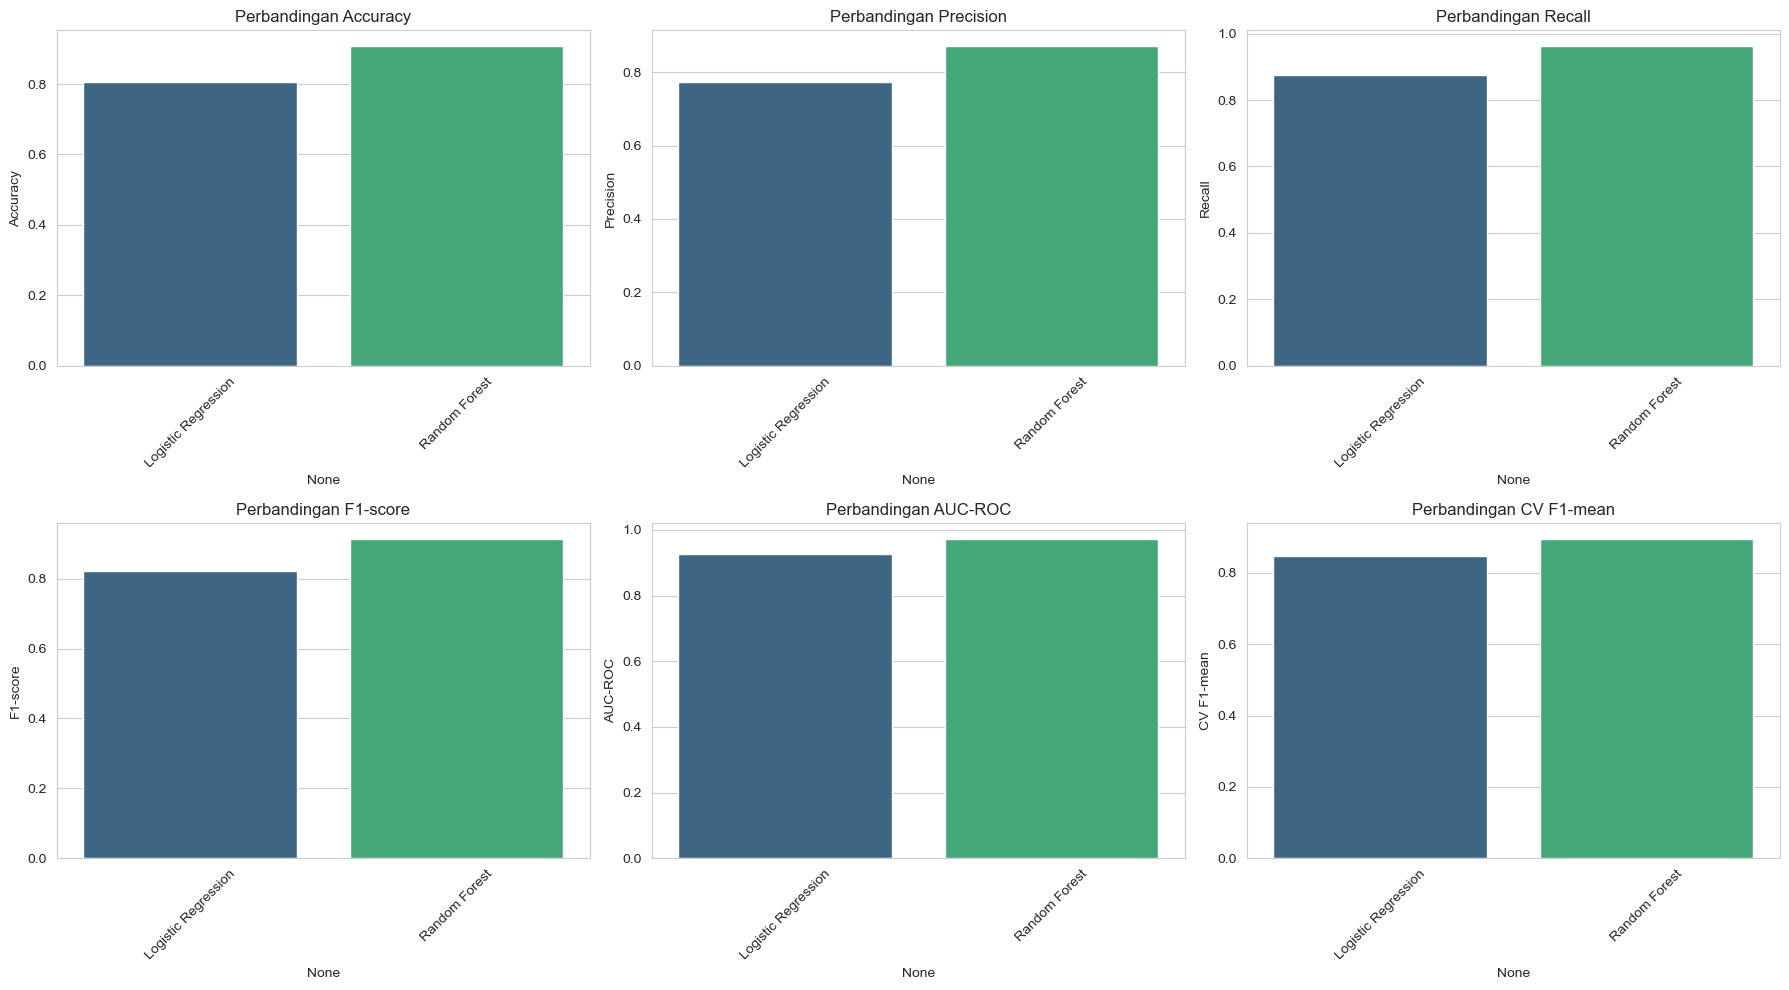


📋 Tabel Perbandingan Metrik:
                     Accuracy Precision    Recall  F1-score   AUC-ROC  \
Logistic Regression  0.804878  0.773109   0.87619  0.821429  0.925333   
Random Forest        0.907317   0.87069  0.961905  0.914027  0.973048   

                    CV F1-mean CV F1-std  
Logistic Regression   0.848688  0.028027  
Random Forest         0.895642  0.015937  


In [6]:
# Konversi hasil ke DataFrame untuk visualisasi
results_df = pd.DataFrame(results).T

# Plot metrik utama
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC', 'CV F1-mean']
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=axes[i], palette='viridis')
    axes[i].set_title(f'Perbandingan {metric}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n📋 Tabel Perbandingan Metrik:")
print(results_df[['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC', 'CV F1-mean', 'CV F1-std']])

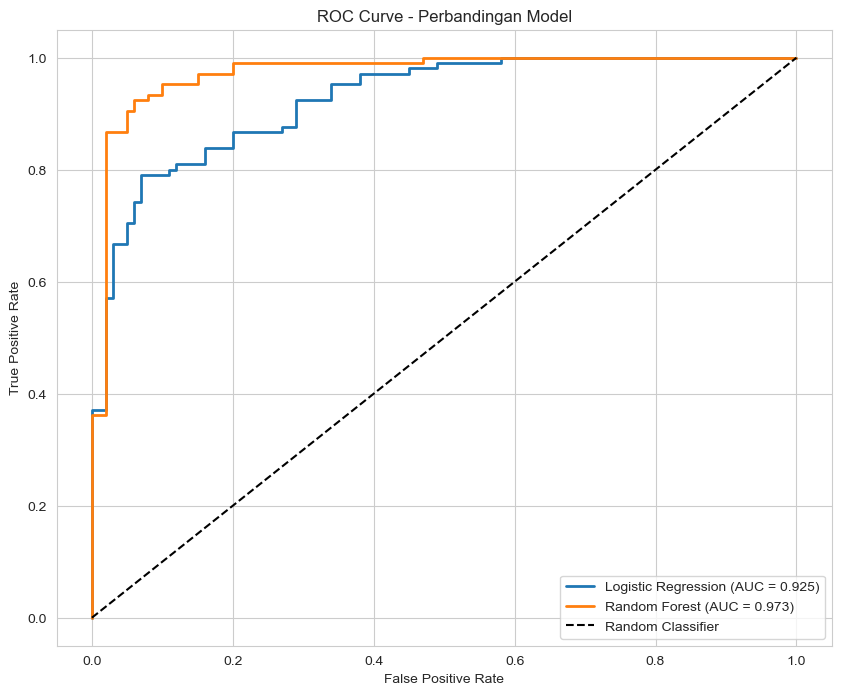

In [7]:
plt.figure(figsize=(10, 8))
for name in models:
    fpr, tpr, _ = roc_curve(y_test, results[name]['Probabilities'])
    auc = results[name]['AUC-ROC']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

plt.plot([0,1], [0,1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Perbandingan Model')
plt.legend()
plt.grid(True)
plt.show()

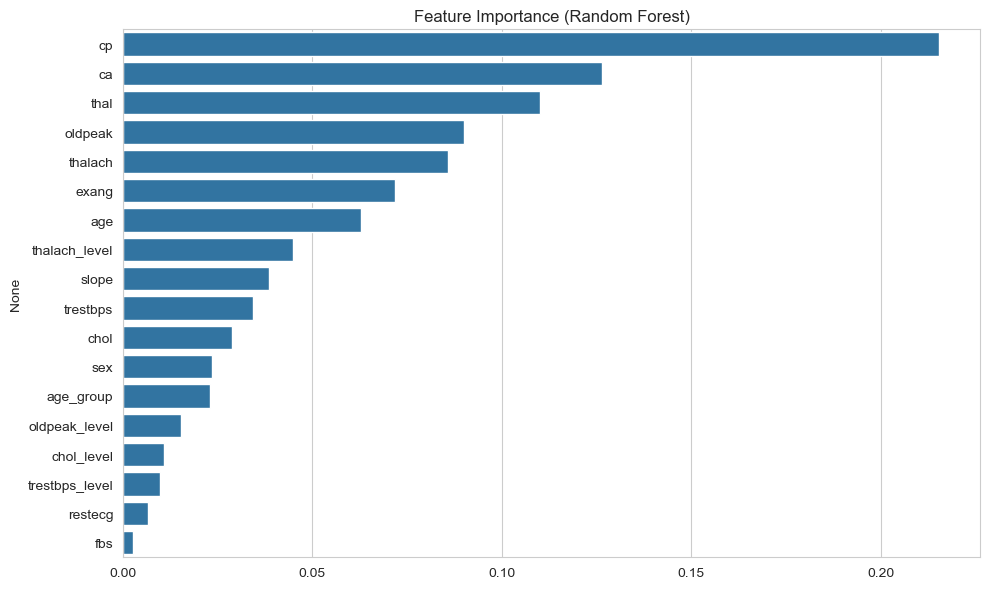


📋 Fitur Paling Penting (Random Forest):
cp               0.215484
ca               0.126478
thal             0.109991
oldpeak          0.090042
thalach          0.085910
exang            0.071722
age              0.062823
thalach_level    0.044811
slope            0.038520
trestbps         0.034225
dtype: float64


In [8]:
if 'Random Forest' in models:
    rf_model = models['Random Forest'].named_steps['model']
    importances = rf_model.feature_importances_
    feature_names = X.columns

    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title("Feature Importance (Random Forest)")
    plt.tight_layout()
    plt.show()

    print("\n📋 Fitur Paling Penting (Random Forest):")
    print(feat_imp.head(10))

In [9]:
import joblib

# Temukan model dengan F1-score tertinggi
best_model_name = max(results, key=lambda x: results[x]['F1-score'])
best_pipeline = models[best_model_name]

print(f"\n🏆 Model terbaik berdasarkan F1-score: {best_model_name}")
print(f"   F1-score: {results[best_model_name]['F1-score']:.4f}")

# Simpan model
joblib.dump(best_pipeline, f"best_heart_disease_model.pkl")
print(f"✅ Model {best_model_name} disimpan sebagai 'best_heart_disease_model.pkl'")


🏆 Model terbaik berdasarkan F1-score: Random Forest
   F1-score: 0.9140
✅ Model Random Forest disimpan sebagai 'best_heart_disease_model.pkl'


In [10]:
import joblib

# Temukan model dengan F1-score tertinggi
best_model_name = max(results, key=lambda x: results[x]['F1-score'])
best_pipeline = models[best_model_name]

print(f"\n🏆 Model terbaik berdasarkan F1-score: {best_model_name}")
print(f"   F1-score: {results[best_model_name]['F1-score']:.4f}")

# Simpan model
joblib.dump(best_pipeline, f"best_heart_disease_model.pkl")
print(f"✅ Model {best_model_name} disimpan sebagai 'best_heart_disease_model.pkl'")


🏆 Model terbaik berdasarkan F1-score: Random Forest
   F1-score: 0.9140
✅ Model Random Forest disimpan sebagai 'best_heart_disease_model.pkl'


In [11]:
# Misalnya input baru dari pasien
new_data = pd.DataFrame({
    'age': [55],
    'sex': [1],
    'cp': [2],
    'trestbps': [140],
    'chol': [250],
    'fbs': [0],
    'restecg': [0],
    'thalach': [150],
    'exang': [1],
    'oldpeak': [2.0],
    'slope': [1],
    'ca': [1],
    'thal': [2],
    'age_group': [2],  # Dewasa Tua
    'chol_level': [2],  # Tinggi
    'thalach_level': [1],  # Sedang
    'trestbps_level': [1],  # Prehipertensi
    'oldpeak_level': [2]  # Sedang
})

# Lakukan prediksi dengan model terbaik
pred_new = best_pipeline.predict(new_data)
pred_proba = best_pipeline.predict_proba(new_data)

print(f"\n🧪 Contoh Prediksi Baru (dengan {best_model_name}):")
print(f"Prediksi: {'Sakit' if pred_new[0] == 1 else 'Sehat'}")
print(f"Probabilitas: {pred_proba[0]}")


🧪 Contoh Prediksi Baru (dengan Random Forest):
Prediksi: Sehat
Probabilitas: [0.60438665 0.39561335]


In [12]:
from sklearn.model_selection import GridSearchCV

# Definisikan model RF yang ingin dituning
rf_model = RandomForestClassifier(random_state=42)

# Pipeline dengan StandardScaler
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', rf_model)
])

# Parameter yang ingin dituning
param_grid = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [5, 7, None],
    'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [2, 5],
    'model__max_features': ['sqrt', 'log2']
}

# GridSearchCV
grid_search_rf = GridSearchCV(
    rf_pipeline, 
    param_grid, 
    cv=5, 
    scoring='f1', 
    n_jobs=-1, 
    verbose=1
)

print("🔍 Mulai tuning Random Forest...")
grid_search_rf.fit(X_train, y_train)

print("✅ Tuning selesai!")
print("🏆 Parameter terbaik:", grid_search_rf.best_params_)
print("🏆 F1-score terbaik (CV):", grid_search_rf.best_score_)

🔍 Mulai tuning Random Forest...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
✅ Tuning selesai!
🏆 Parameter terbaik: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 50}
🏆 F1-score terbaik (CV): 0.9691765637652698


In [13]:
import joblib

# Simpan model
joblib.dump(rf_pipeline, "final_heart_disease_model.pkl")
print("✅ Model disimpan sebagai 'final_heart_disease_model.pkl'")

✅ Model disimpan sebagai 'final_heart_disease_model.pkl'
